# 03. 평가

- 성능 평가 지표(Evaluation Metric)
- 회귀 : 대부분 실제값과 예측값의 오차 평균값에 기반
- 분류 (0이냐, 1이냐 혹은 긍정/부정을 판단하는 이진 분류) : '정확도(Accuracy)'보다는 다른 성능 평가 지표가 중요
- 분류에는 크게 **이진 분류**와 **멀티 분류**로 나뉨

**분류**의 성능 평가 지표
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

## 1. 정확도(Accuracy)

$$ \text{정확도(Accuracy)} = \frac{\text{예측 결과가 동일한 데이터 건수}}{\text{전체 예측 데이터 건수}} $$  
하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있음

In [1]:
from sklearn.base import BaseEstimator  #개발자가 Customized 형태의 Estimator를 생성할 수 있음

class MyDummyClassifier(BaseEstimator):  # 이 클래스의 멤버 함수는 fit()과 predict()임
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))  # X의 행의 수만큼 0을 채움
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:  # (복습) iloc은 인덱스 기반의 위치 선택
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

In [2]:
# transform_features() : Null 처리, 불필요한 피처 제거, 인코딩을 수행하는 내부 함수로 구성 (데이터의 전처리를 전체적으로 호출)
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:  # Cabin, Sex, Embarked column들의 값을 반복문 사용해서 레이블인코딩 수행
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):  # NaN, 불필요한 값, 인코딩 동시 수행
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
# 생성된 MyDummyClassifier를 이용해 앞 장의 타이타닉 생존자 예측 수행
import pandas as pd
import numpy as np  # transform_features()를 위해서 numpy 모듈 사용
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder # transform_features()를 위해서 numpy 모듈 사용

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)  # 아무것도 학습하지 않음

mypredictions = myclf.predict(X_test)  #Sex 피처가 1이면 0, 0이면 1로 예측함
print('Dummy Classifier의 정확도는: {0:.4f}.'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877.


cf) 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과는 높은 수치가 나올 수 있음  
cf) 불균형한 레이블 값 분포에서의 ML 모델의 성능을 판단할 경우에도 적합한 평가 지표는 아님

In [4]:
from sklearn.datasets import load_digits  # 사이킷런은 MNIST 데이터 세트 제공
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator  # 클래스 custom을 위해 도입
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
# 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 바꿈 (원래는 멀티 레이블 분류)
class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)  # boolean배열을 정수형으로 변환하는 메서드 (True면 1로, False면 0으로)
# True는 1로, False는 0으로 구성된 배열로 바뀜
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())  # DataFrame의 y_test 칼럼값 카운트

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)  # pass로 인해 수행 x
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
Name: count, dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900000


## 2. 오차 행렬

분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표  
**어떠한 유형의 예측 오류**가 발생하고 있는지를 함께 나타내는 지표

- TN(True Negative) : Negative 값 0으로 예측했고, 실제 값 역시 Negative 값 0
- FP(False Positive) : Positive 값 1로 예측했고, 실제 값은 Negative 값 0
- FN(False Negative) : Negative 값 0으로 예측했고, 실제 값은 Positive 값 1
- TP(True Positive) : Positive 값 1로 예측했고, 실제 값 역시 Positive 값 1

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)  #출력된 오차 행렬은 ndarray 형태
#fakepred는 무조건 Negative로 예측하는 Classifier로 데이터 세트의 클래스 값 분포는 0이 405건, 1이 45건
# 전체 450건을 모두 Negative 0으로 예측해서 Positive 값은 0임

array([[405,   0],
       [ 45,   0]], dtype=int64)

$$ \text{정확도(Accuracy)} = \frac{\text{예측 결과가 동일한 데이터 건수}}{\text{전체 예측 데이터 건수}} = \frac{\text{(TN + TP)}}{\text{(TN + FP + FN + TP)}} $$  

cf) 일반적으로 찾아야 하는 매우 적은 수의 결괏값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우는 Negative로 0 값을 부여하는 경우가 많음  
-> 일반적인 경우라면 TN은 매우 커지고 TP는 매우 작아지게 됨  
-> (Negative로 예측할 때 정확도가 높으므로) FN이 매우 작고, FP는 매우 작음  
  
  - 즉 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로 분류의 정확도가 매우 높게 나타나는 **수치적인 판단 오류** 발생  
  - 그래서 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표인 '정밀도'와 '재현율' 사용

## 3. 정밀도와 재현율

Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표  
cf) MyFakeClassifier는 Positive로 예측한 TP 값이 하나도 없기 때무누에 정밀도와 재현율 값이 모두 0임

**정밀도** = TP / (FP + TP) : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 (양성 예측도라 불림)  
**재현율** = TP / (FN + TP) : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 (민감도 또는 TPR로 불림)  
- 정밀도가 중요한 예시 : 암 환자, 금융 사기
- 재현율이 중요한 예시 : 스팸 메일

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
# confusion matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 함수 get_clf_eval()
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)  # confusion matrix 생성
    accuracy = accuracy_score(y_test, pred)  # 정확도 계산
    precision = precision_score(y_test, pred)  # 정밀도 계산
    recall = recall_score(y_test, pred)  # 재현율 계산
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size = 0.20, random_state = 11)
lr_clf = LogisticRegression(solver = 'liblinear')  # 로지스틱 회귀의 최적화 알고리즘 유형을 지정하는 것 (작은 데이터 세트의 이진 분류)
                                                   # Chap05에서 자세히 다룰 예정
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


### 정밀도/재현율 트레이드오프

정밀도와 재현율은 **상호 보완적**인 평가 지표이기 때문에 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움

사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba() 제공  
입력 파라미터는 predict() 메서드와 동일하게 보통 테스트 피처 데이터 세트를 입력  
개별 클래스의 예측 확률을 ndarray m x n 형태로 변환 (m은 입력값의 레코드 수, n은 클래스 값 유형)

In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


In [10]:
from sklearn.preprocessing import Binarizer  # Binarizer 클래스 사용법 예제

X=[[1, -1, 2],
  [2, 0, 0],
  [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)  # threshold를 통해 기준값 설정
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [12]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)  # 재현율 값이 올라가고 정밀도가 떨어졌음
# Positive 예측값이 많아지면 상대적으로 재현율 값이 높아짐 -> 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 감소

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


In [13]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


In [14]:
from sklearn.metrics import precision_recall_curve  # 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 계산

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

# 임곗값이 증가할수록 정밀도 값은 높아지고, 재현율 값은 낮아짐

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도:  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


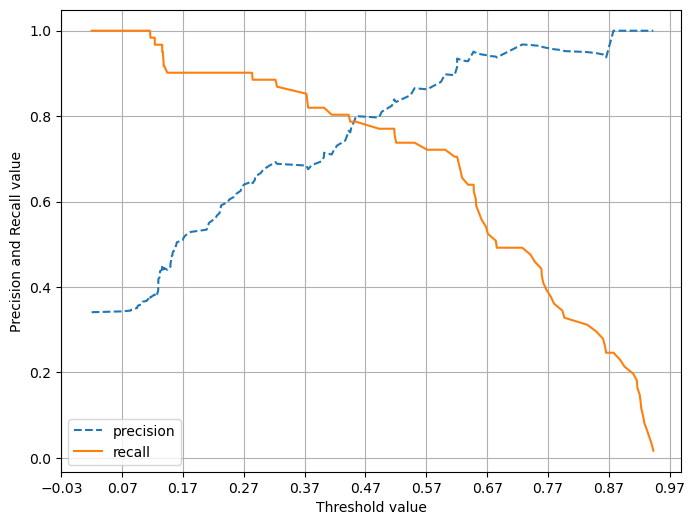

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Sclae을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

-> 이는 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고, 정밀도 값이 극도로 낮아짐을 알 수 있다.  
-> 임곗값을 계속 증가시킬수록 재현율 값이 낮아지고, 정밀도 값이 높아지는 반대의 양상이 됨

### 정밀도와 재현율의 맹점

Positive 예측의 임곗값을 변경함에 따라 **정밀도와 재현율의 수치**가 변경됨

**정밀도가 100%가 되는 방법**

ex) 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive인 경우  
한 명만 Positive로 예측하고 나머지는 모두 Negative로 예측하더라도 FP는 0, TP는 1이므로 정밀도는 100%가 됨

**재현율이 100%가 되는 방법**

ex) 모든 환자를 Positive로 예측

## 4. F1 스코어

정밀도와 재현율을 결합한 지표 -> 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타날 때 높은 값을 가짐

$$ \text{F1} = 2* \frac{\text{precision*recall}}{\text{precision+recall}}$$  
ex) A 예측 모델의 경우 -> 정밀도 : 0.9, 재현율 : 0.1 / B 예측 모델의 경우 -> 정밀도 : 0.5, 재현율 : 0.5  
B 예측 모델이 A에 비해 매우 우수한 F1 스코어를 가짐

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [17]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
          
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000


## 5. ROC 곡선과 AUC

- 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표  

- **ROC 곡선** :  
 1) 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표
 2) FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선
 3) FPR을 x축으로, TPR을 y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타남
 4) 이때 TPR은 재현율임 (TP/(FN+TP))
 5) TPR은 민감도로도 불림 / 대응하는 지표로 TNR(True Negative Rate)이라고 불리는 특이성이 있음
  
TPR(민감도)는 실제값 Positive가 정확히 예측돼야 하는 수준을 나타냄 (질병이 있는 사람은 질병이 있는 것으로 양성 판정)  
TNR(특이성)은 실제값 Negative가 정확히 예측돼야 하는 수준을 나타냄 (질병이 없는 건강한 사람은 질병이 없는 것으로 음성 판정)  
  
  TNR = TN/(FP+TN)  
  FPR = FP/(FP+TN) -> 1 - TNR, 1 - 특이성  
  cf) AUC는 ROC 곡선 면적에 기반한 값

1) FPR을 0으로 만드는 방법
: 임곗값을 1로 설정하면 됨 -> Positive로 예측할 수 없기 때문에 FP 값이 0이 되므로 FPR이 0이 됨
2) FPR을 1로 만드는 방법
: 임곗값을 0으로 설정하면 됨 -> Negative로 예측할 수 없기 때문에 TN 값이 0이 되므로 FPR이 1이 됨

사이킷런은 ROC 곡선을 구하기 위해 roc_curve() API 제공

In [18]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Steps으로 추출.
# threshold[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
# ROC 곡선의 시작점을 (0,0)에 위치시키기 위한 것
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TRP:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TRP: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


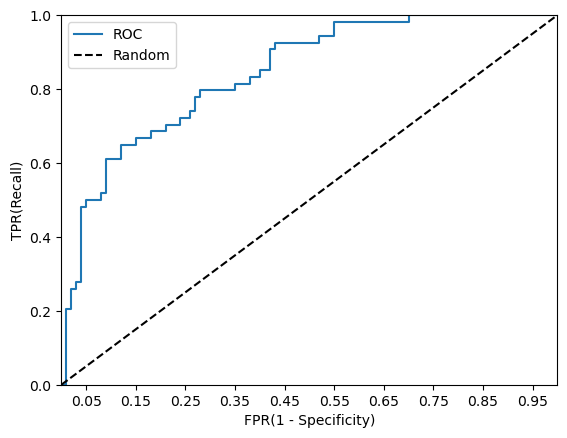

In [48]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X 축의 Sclae을 0.1 단위로 변경, X, Y 축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1 - Specificity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [20]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


In [47]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 6. 피마 인디언 당뇨병 예측

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())  # Negative가 상대적으로 많은 데이터셋
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [50]:
diabetes_data.info()  # Null 값은 없으며 피처의 타입은 모두 숫자형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [51]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 156, stratify = y)
# stratify = y는 훈련 데이터 세트와 테스트 데이터 세트가 원본 데이터 세트의 클래스 비율을 유지하도록 하는 것
# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,          F1: 0.6465, AUC:0.8083


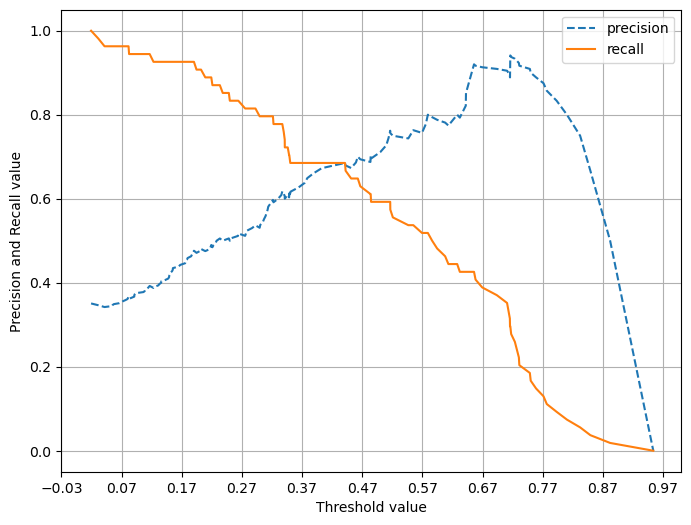

In [52]:
# 정밀도 재현율 곡선을 보고, 임곗값별 정밀도와 재현율 값의 변화 확인
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [53]:
# 임곗값이 0.42 정도가 되면 정밀도와 재현율이 어느 정도 균형을 맞춤
# 하지만 두 개의 지표 모두 0.7이 안 되는 수치임
diabetes_data.describe()  # 포도당 수치가 0인 것은 말이 안 됨... min() 값이 0인 것이 상당히 많음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


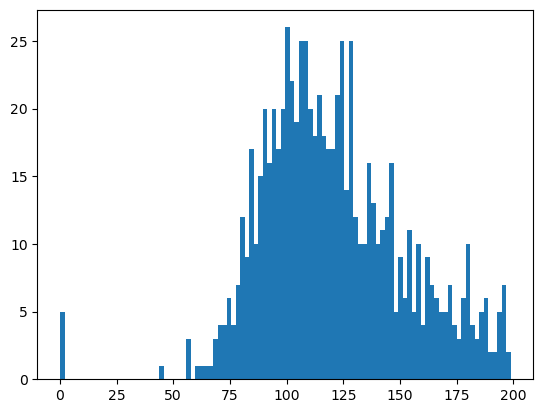

In [54]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [55]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [56]:
# zero_features 리스트 내부에 저장된 개별 피더릉게 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [57]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이트 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,          F1: 0.6804, AUC:0.8433


In [58]:
from sklearn.preprocessing import Binarizer  # 이것을 최신화해주지 않으니 invalidParameterError가 뜸

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)  # 새롭게 정의된 get_clf_eval을 최신화해줘야 함

In [59]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,          F1: 0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,          F1: 0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,          F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,          F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,          F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,          F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,          F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,          F1: 0.6804, AUC:0.8433


In [60]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)
# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,          F1: 0.6931, AUC:0.8433
